# Decision Analysis - Project 2

### UTA Method

---
**Team members:**

- Sofya Aksenyuk, 150284
- Uladzimir Ivashka, 150281

---

## Libraries

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from pulp import *  
import re
import copy
from scipy.interpolate import interp1d

## Dataset

In [2]:
df = pd.read_csv('Dataset.csv')

In [3]:
df = df.set_index('Alternative')

In [4]:
df

,g1_(gain),g2_(gain),g3_(gain),g4_(cost)
Alternative,,,,
a1,98,8,140,400
a2,58,0,123,800
a3,66,5,128,1000
a4,74,3,106,600
a5,80,7,147,200
a6,82,10,118,600
a7,58,1,109,200
a8,73,12,132,800
a9,92,9,121,500


In [5]:
df.describe()

,g1_(gain),g2_(gain),g3_(gain),g4_(cost)
count,12.000000,12.000000,12.000000,12.000000
mean,77.416667,5.750000,123.333333,575.000000
std,14.177180,3.646293,15.552453,259.807621
min,58.000000,0.000000,105.000000,200.000000
25%,66.750000,3.000000,108.250000,375.000000
50%,77.000000,5.500000,122.000000,600.000000
75%,84.500000,8.250000,134.000000,800.000000
max,100.000000,12.000000,147.000000,1000.000000


---

There are **twelve alternatives**, each of them representing a house to buy, e.g.:

- a1 - one-store countryside house of 140 $m^2$ area with the garage of 98 $m^2$ and garden of 8 hectares. All for the cost of 400'000 USD.

There are **four criterias** describing a place, taken from a local estate agency website:

- g1 - garage area (in $m^2$) 
- g2 - garden size (in hectares)
- g3 - living area (in $m^2$)
- g4 - cost (in thousands USD)

where, we would like to maximize first three criterias for as less price as possible.

Decision Maker stated their preferences on the importance of each criteria. Therefore, the **weights** are different for each of them. Each of them is relevant, but garden area (g2) is of least priority. The weights are as follows:

- [3, 1, 4, 6]

for criterias [g1, g2, g3, g4] respectively.

Ranges of each criteria values:

- g1: 58-100 ($m^2$) (gain type)
- g2: 0-10 (hectares) (gain type)
- g3: 105-147 ($m^2$) (gain type)
- g4: 200-1000 (thousands USD) (cost type)

where, all of them are continious.

## LP Model

---
### Apriori

Pairwise ranking comparison:

- a8 is preferred to a7 
- a3 is preferred to a1 <- inconsistency
- a5 is preferred to a1 
- a7 is preferred to a4 
- a3 is preferred to a2
- a1 is preferred to a6
- a4 is preferred to a2
- a9 is preferred to a3
- a10 is preferred to a1
- a12 is preferred to a10 <- inconsistency
- a5 is preferred to a6
- a5 is preferred to a12
- a1 is preferred to a9

**Note:** There is no indifference in the dataset.

### Inconsistency added to LP Model

- a3 is preferred to a1, when it is actually the opposite
- a12 is preferred to a10, when it is actually the opposite

---

In [6]:
def srf(weights, min_dif=1):
    sorted_weights = weights.sort_values()
    ratio = [sorted_weights.iloc[0]]
    for i in range(1, len(sorted_weights)):
        ratio.extend((sorted_weights.iloc[i] - sorted_weights.iloc[i-1] - min_dif) * ['wc'])
        ratio.append(sorted_weights.iloc[i])
    print('Ratio:', ratio)
    r = []
    wg = dict()
    for i in range(len(ratio)):
        if ratio[i] != 'wc':
            wcs = ratio[:i].count('wc')
            r.append(i+1)
            wg[ratio[i]] = 1 + (len(ratio) - 1) * (i) / (len(ratio) - 1)

    norm = {k: v/sum(wg.values()) for k, v in wg.items()}
    norm = [norm[i] for i in weights]
    print('Normalized weights:', norm)
    return norm

In [7]:
def uta_model(df, pairwise_comparisons, problem_name):
    model = LpProblem(problem_name, LpMinimize)
    epsilon = 0.001

    pairwise_comparisons_ = copy.deepcopy(pairwise_comparisons)
    binary_vars = LpVariable.dicts('binary_variable', pairwise_comparisons_, lowBound=0, cat='Binary')
    model += lpSum(list(binary_vars.values()))

    names = list(map(lambda x: str(x[0]) + '_' + str(x[1]), zip(df.loc['a1'].values, df.columns)))
    criteria_vars = dict()
    for idx in df.index:
        cur_var = LpVariable.dicts(idx, names, lowBound=0, cat='Continuous')
        criteria_vars[idx] = dict(zip(df.columns, cur_var.values()))

    for alt1, alt2 in pairwise_comparisons:
        model += lpSum(list(criteria_vars[alt1].values())) >= lpSum(list(criteria_vars[alt2].values())) - binary_vars[tuple([alt1, alt2])] + epsilon
        
    alphas, betas, sorted_alternatives = {}, {}, {}
    for criteria in df.columns:
        criteria_type = re.search('\((.+?)\)', criteria).group(1) 
        min_value = df.index[np.argmin(df[criteria])]
        max_value = df.index[np.argmax(df[criteria])]
        
        if criteria_type == 'cost':
            sorted_alternatives[criteria] = list(df[criteria].sort_values(ascending=True).index)
            min_value, max_value = max_value, min_value
        else:
            sorted_alternatives[criteria] = list(df[criteria].sort_values(ascending=False).index)
            
        alphas[criteria] = min_value
        betas[criteria] = max_value

    betas_values = list()
    for criteria in df.columns:
        model += criteria_vars[alphas[criteria]][criteria] == 0 
        betas_values.append(criteria_vars[betas[criteria]][criteria])
        
    model += lpSum(betas_values) == 1

    for criteria, alts in sorted_alternatives.items():
        for idx in range(1, len(alts)):
            model += criteria_vars[alts[idx-1]][criteria] - criteria_vars[alts[idx]][criteria] >= 0

    return model

# Model with inconsistencies

In [8]:
dominant_alternatives_inc = ['a8', 'a3', 'a5', 'a7', 'a3', 'a1', 'a4', 'a9', 'a10', 'a12', 'a5', 'a5', 'a1']
dominated_alternatives_inc = ['a7', 'a1', 'a1', 'a4', 'a2', 'a6', 'a2', 'a3', 'a1', 'a10', 'a6', 'a12', 'a9']
pairwise_comparisons_inc = list(zip(dominant_alternatives_inc, dominated_alternatives_inc))

In [9]:
model_inc = uta_model(df, pairwise_comparisons_inc, 'house-problem-with-inconsistency')
status = model_inc.solve(solver = GLPK())

## Model objective

In [10]:
print(f"status: {model_inc.status}, {LpStatus[model_inc.status]}")
print(f"objective: {model_inc.objective.value()}")

status: 1, Optimal
objective: 2


---
Objective function value greater than zero constitues to the presence of inconsistencies.

---

## Model variables' optimized values and found inconsistencies

In [11]:
for var in model_inc.variables():
    if 'binary_variable' in var.name and var.value() > 0:
        print(f"{var.name}: {var.value()} <- inconsistency")
    else:
        print(f"{var.name}: {var.value()}")

a10_140_g3_(gain): 0.002
a10_400_g4_(cost): 0.0
a10_8_g2_(gain): 0.0
a10_98_g1_(gain): 0.003
a11_140_g3_(gain): 0.0
a11_400_g4_(cost): 0.0
a11_8_g2_(gain): 0.0
a11_98_g1_(gain): 0.001
a12_140_g3_(gain): 0.0
a12_400_g4_(cost): 0.0
a12_8_g2_(gain): 0.0
a12_98_g1_(gain): 0.0
a1_140_g3_(gain): 0.002
a1_400_g4_(cost): 0.0
a1_8_g2_(gain): 0.0
a1_98_g1_(gain): 0.002
a2_140_g3_(gain): 0.0
a2_400_g4_(cost): 0.0
a2_8_g2_(gain): 0.0
a2_98_g1_(gain): 0.0
a3_140_g3_(gain): 0.002
a3_400_g4_(cost): 0.0
a3_8_g2_(gain): 0.0
a3_98_g1_(gain): 0.0
a4_140_g3_(gain): 0.0
a4_400_g4_(cost): 0.0
a4_8_g2_(gain): 0.0
a4_98_g1_(gain): 0.001
a5_140_g3_(gain): 0.002
a5_400_g4_(cost): 0.994
a5_8_g2_(gain): 0.0
a5_98_g1_(gain): 0.001
a6_140_g3_(gain): 0.0
a6_400_g4_(cost): 0.0
a6_8_g2_(gain): 0.001
a6_98_g1_(gain): 0.002
a7_140_g3_(gain): 0.0
a7_400_g4_(cost): 0.002
a7_8_g2_(gain): 0.0
a7_98_g1_(gain): 0.0
a8_140_g3_(gain): 0.002
a8_400_g4_(cost): 0.0
a8_8_g2_(gain): 0.001
a8_98_g1_(gain): 0.0
a9_140_g3_(gain): 0.0
a

---
As it can be seen, the model detected the inconsistencies: `(a12, a10)` and `(a3, a1)`.

---

## Model constraints

In [12]:
for constraint in model_inc.constraints.values():
    print("[•] ", constraint)

[•]  -a7_140_g3_(gain) - a7_400_g4_(cost) - a7_8_g2_(gain) - a7_98_g1_(gain) + a8_140_g3_(gain) + a8_400_g4_(cost) + a8_8_g2_(gain) + a8_98_g1_(gain) + binary_variable_('a8',_'a7') >= 0.001
[•]  -a1_140_g3_(gain) - a1_400_g4_(cost) - a1_8_g2_(gain) - a1_98_g1_(gain) + a3_140_g3_(gain) + a3_400_g4_(cost) + a3_8_g2_(gain) + a3_98_g1_(gain) + binary_variable_('a3',_'a1') >= 0.001
[•]  -a1_140_g3_(gain) - a1_400_g4_(cost) - a1_8_g2_(gain) - a1_98_g1_(gain) + a5_140_g3_(gain) + a5_400_g4_(cost) + a5_8_g2_(gain) + a5_98_g1_(gain) + binary_variable_('a5',_'a1') >= 0.001
[•]  -a4_140_g3_(gain) - a4_400_g4_(cost) - a4_8_g2_(gain) - a4_98_g1_(gain) + a7_140_g3_(gain) + a7_400_g4_(cost) + a7_8_g2_(gain) + a7_98_g1_(gain) + binary_variable_('a7',_'a4') >= 0.001
[•]  -a2_140_g3_(gain) - a2_400_g4_(cost) - a2_8_g2_(gain) - a2_98_g1_(gain) + a3_140_g3_(gain) + a3_400_g4_(cost) + a3_8_g2_(gain) + a3_98_g1_(gain) + binary_variable_('a3',_'a2') >= 0.001
[•]  a1_140_g3_(gain) + a1_400_g4_(cost) + a1_8_g2

# Model without inconsistencies

In [13]:
dominant_alternatives_no_inc = ['a8', 'a5', 'a7', 'a3', 'a1', 'a4', 'a9', 'a10', 'a5', 'a1', 'a5']
dominated_alternatives_no_inc = ['a7', 'a1', 'a4', 'a2', 'a6', 'a2', 'a3', 'a1', 'a6', 'a9', 'a12']
pairwise_comparisons_no_inc = list(zip(dominant_alternatives_no_inc, dominated_alternatives_no_inc))

In [14]:
model_no_inc = uta_model(df, pairwise_comparisons_no_inc, 'house-problem-no-inconsistency')
status = model_no_inc.solve(solver = GLPK())

## Model objective

In [15]:
print(f"status: {model_no_inc.status}, {LpStatus[model_no_inc.status]}")
print(f"objective: {model_no_inc.objective.value()}")

status: 1, Optimal
objective: 0


---
There are no inconsistencies, therefore, the objective function value is equal to 0.

---

## Model constraints

In [16]:
for constraint in model_no_inc.constraints.values():
    print("[•] ", constraint)

[•]  -a7_140_g3_(gain) - a7_400_g4_(cost) - a7_8_g2_(gain) - a7_98_g1_(gain) + a8_140_g3_(gain) + a8_400_g4_(cost) + a8_8_g2_(gain) + a8_98_g1_(gain) + binary_variable_('a8',_'a7') >= 0.001
[•]  -a1_140_g3_(gain) - a1_400_g4_(cost) - a1_8_g2_(gain) - a1_98_g1_(gain) + a5_140_g3_(gain) + a5_400_g4_(cost) + a5_8_g2_(gain) + a5_98_g1_(gain) + binary_variable_('a5',_'a1') >= 0.001
[•]  -a4_140_g3_(gain) - a4_400_g4_(cost) - a4_8_g2_(gain) - a4_98_g1_(gain) + a7_140_g3_(gain) + a7_400_g4_(cost) + a7_8_g2_(gain) + a7_98_g1_(gain) + binary_variable_('a7',_'a4') >= 0.001
[•]  -a2_140_g3_(gain) - a2_400_g4_(cost) - a2_8_g2_(gain) - a2_98_g1_(gain) + a3_140_g3_(gain) + a3_400_g4_(cost) + a3_8_g2_(gain) + a3_98_g1_(gain) + binary_variable_('a3',_'a2') >= 0.001
[•]  a1_140_g3_(gain) + a1_400_g4_(cost) + a1_8_g2_(gain) + a1_98_g1_(gain) - a6_140_g3_(gain) - a6_400_g4_(cost) - a6_8_g2_(gain) - a6_98_g1_(gain) + binary_variable_('a1',_'a6') >= 0.001
[•]  -a2_140_g3_(gain) - a2_400_g4_(cost) - a2_8_g2

## Model variables' optimized values

In [17]:
criteria_function_values = dict()
for var in model_no_inc.variables():
    if 'binary_variable' in var.name and var.value() > 0:
        print(f"{var.name}: {var.value()} <- inconsistency")
    else:
        print(f"{var.name}: {var.value()}")
        if 'binary_variable' not in var.name:
            criteria_name = re.search('g(.+?)\)', var.name).group(0)
            criteria_function_values.setdefault(criteria_name, []).append(var.value())

a10_140_g3_(gain): 0.0
a10_400_g4_(cost): 0.0
a10_8_g2_(gain): 0.001
a10_98_g1_(gain): 0.994
a11_140_g3_(gain): 0.0
a11_400_g4_(cost): 0.0
a11_8_g2_(gain): 0.001
a11_98_g1_(gain): 0.0
a12_140_g3_(gain): 0.0
a12_400_g4_(cost): 0.0
a12_8_g2_(gain): 0.001
a12_98_g1_(gain): 0.0
a1_140_g3_(gain): 0.0
a1_400_g4_(cost): 0.0
a1_8_g2_(gain): 0.001
a1_98_g1_(gain): 0.002
a2_140_g3_(gain): 0.0
a2_400_g4_(cost): 0.0
a2_8_g2_(gain): 0.0
a2_98_g1_(gain): 0.0
a3_140_g3_(gain): 0.0
a3_400_g4_(cost): 0.0
a3_8_g2_(gain): 0.001
a3_98_g1_(gain): 0.0
a4_140_g3_(gain): 0.0
a4_400_g4_(cost): 0.0
a4_8_g2_(gain): 0.001
a4_98_g1_(gain): 0.0
a5_140_g3_(gain): 0.002
a5_400_g4_(cost): 0.001
a5_8_g2_(gain): 0.001
a5_98_g1_(gain): 0.0
a6_140_g3_(gain): 0.0
a6_400_g4_(cost): 0.0
a6_8_g2_(gain): 0.001
a6_98_g1_(gain): 0.0
a7_140_g3_(gain): 0.0
a7_400_g4_(cost): 0.001
a7_8_g2_(gain): 0.001
a7_98_g1_(gain): 0.0
a8_140_g3_(gain): 0.0
a8_400_g4_(cost): 0.0
a8_8_g2_(gain): 0.003
a8_98_g1_(gain): 0.0
a9_140_g3_(gain): 0.0
a

# Marginal utility function plots

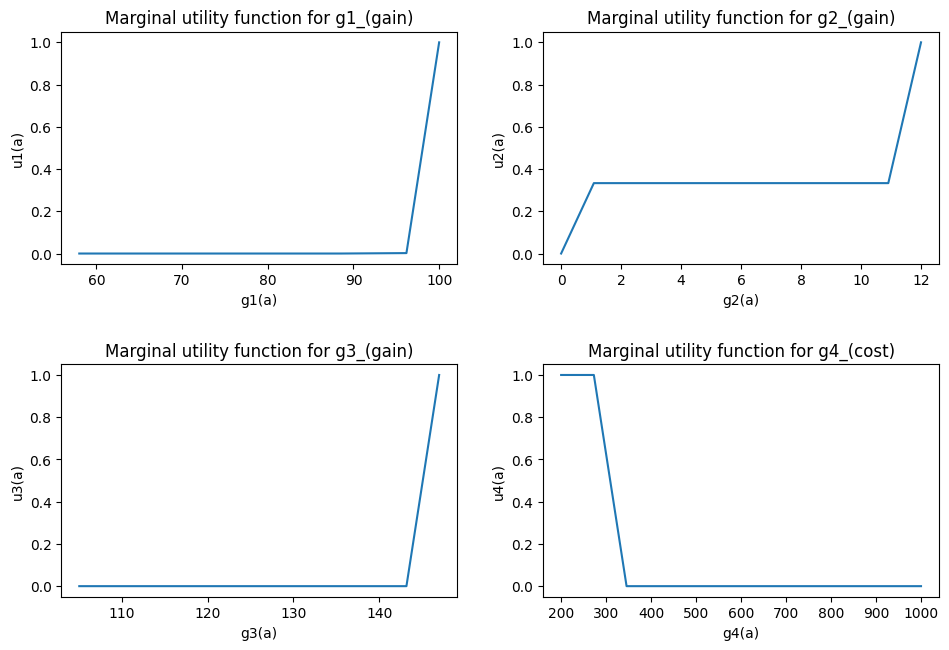

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax = ax.ravel()

criteria_function_values = dict(sorted(criteria_function_values.items()))
math_functions = dict()
for i, (k, v) in enumerate(criteria_function_values.items()):
    criteria_type = re.search('\((.+?)\)', k).group(1)
    v = sorted(v, reverse=bool(criteria_type=='cost'))
    v = np.array(v)
    v = (v - min(v)) / (max(v) - min(v)) ## scaling to the same max utility value

    x = np.linspace(min(df[k]), max(df[k]), len(v))
    math_functions[k] = interp1d(x, v)

    ax[i].plot(x, v)
    ax[i].set_title(f'Marginal utility function for {k}')
    ax[i].set_ylabel(f'u{i+1}(a)')
    ax[i].set_xlabel(f'g{i+1}(a)')

fig.tight_layout(pad=2.5)

# UTA Ranking

In [19]:
def get_addval_matrix(df, math_functions, weights):
    matrix = pd.DataFrame(index=df.index)
    for idx, col in enumerate(df.columns):
      matrix[f'u{idx+1}'] = df[col].apply(math_functions[col])
      
    matrix['U'] = np.sum(matrix * weights, axis=1)
    
    return matrix

In [20]:
equal_weights = [1, 1, 1, 1]
mat_equal_weights = get_addval_matrix(df, math_functions, equal_weights)
mat_equal_weights

,u1,u2,u3,u4,U
Alternative,,,,,
a1,0.477244,0.333333,0.000000,0.000,0.810578
a2,0.000000,0.000000,0.000000,0.000,0.000000
a3,0.000000,0.333333,0.000000,0.000,0.333333
a4,0.000000,0.333333,0.000000,0.000,0.333333
a5,0.000000,0.333333,1.000000,1.000,2.333333
a6,0.000000,0.333333,0.000000,0.000,0.333333
a7,0.000000,0.305556,0.000000,1.000,1.305556
a8,0.000000,1.000000,0.000000,0.000,1.000000
a9,0.000910,0.333333,0.000000,0.000,0.334244


In [21]:
ranking_equal_weights = mat_equal_weights.sort_values(by='U', ascending=False).index
ranking_equal_weights

Index(['a10', 'a5', 'a7', 'a8', 'a1', 'a9', 'a3', 'a4', 'a6', 'a11', 'a12',
       'a2'],
      dtype='object', name='Alternative')

In [22]:
weights = srf(pd.Series([3, 1, 4, 6]))
mat_with_weights = get_addval_matrix(df, math_functions, weights)
mat_with_weights

Ratio: [1, 'wc', 3, 4, 'wc', 6]
Normalized weights: [0.21428571428571427, 0.07142857142857142, 0.2857142857142857, 0.42857142857142855]


,u1,u2,u3,u4,U
Alternative,,,,,
a1,0.477244,0.333333,0.000000,0.000,0.126076
a2,0.000000,0.000000,0.000000,0.000,0.000000
a3,0.000000,0.333333,0.000000,0.000,0.023810
a4,0.000000,0.333333,0.000000,0.000,0.023810
a5,0.000000,0.333333,1.000000,1.000,0.738095
a6,0.000000,0.333333,0.000000,0.000,0.023810
a7,0.000000,0.305556,0.000000,1.000,0.450397
a8,0.000000,1.000000,0.000000,0.000,0.071429
a9,0.000910,0.333333,0.000000,0.000,0.024005


In [23]:
ranking_with_weights = mat_with_weights.sort_values(by='U', ascending=False).index
ranking_with_weights

Index(['a5', 'a10', 'a7', 'a1', 'a8', 'a9', 'a3', 'a4', 'a6', 'a11', 'a12',
       'a2'],
      dtype='object', name='Alternative')

## Result Comparison

**Note:** PROMETHEE Methods' ranks are taken from the previous project.

In [24]:
promethee2_rank = np.array(['a10', 'a5', 'a1', 'a9', 'a6', 'a8', 'a7', 'a4', 'a11', 'a3', 'a2', 'a12'])
promethee1_pos_rank = np.array(['a10', 'a5', 'a1', 'a9', 'a7', 'a6', 'a8', 'a3', 'a4', 'a2', 'a11', 'a12'])
promethee1_neg_rank = np.array(['a10', 'a5', 'a1', 'a9', 'a6', 'a8', 'a7', 'a4', 'a11', 'a2', 'a12', 'a3'])
uta_rank_equal_weights = np.array(ranking_equal_weights)
uta_rank_with_weights = np.array(ranking_with_weights)

print('Ranks of all methods:')
print(promethee2_rank, '<- PROMETHEE II')
print(uta_rank_equal_weights, '<- UTA equal weights')
print(uta_rank_with_weights, '<- UTA weights applied')
print(promethee1_pos_rank, '<- PROMETHEE I Ф+')
print(promethee1_neg_rank, '<- PROMETHEE I Ф-')

Ranks of all methods:
['a10' 'a5' 'a1' 'a9' 'a6' 'a8' 'a7' 'a4' 'a11' 'a3' 'a2' 'a12'] <- PROMETHEE II
['a10' 'a5' 'a7' 'a8' 'a1' 'a9' 'a3' 'a4' 'a6' 'a11' 'a12' 'a2'] <- UTA equal weights
['a5' 'a10' 'a7' 'a1' 'a8' 'a9' 'a3' 'a4' 'a6' 'a11' 'a12' 'a2'] <- UTA weights applied
['a10' 'a5' 'a1' 'a9' 'a7' 'a6' 'a8' 'a3' 'a4' 'a2' 'a11' 'a12'] <- PROMETHEE I Ф+
['a10' 'a5' 'a1' 'a9' 'a6' 'a8' 'a7' 'a4' 'a11' 'a2' 'a12' 'a3'] <- PROMETHEE I Ф-


---
As it can be seen, the best and worst alternatives found by different methods are nearly the same, except `(a5, a10)`, `(a12, a2)` pairs of alternatives "switching" the places.

---

In [25]:
def get_kendalls_tau(rank1, rank2):
    d = 0.5 * sum(rank1 != rank2)
    m = len(rank2)
    t = 1 - 4 * (d / (m * (m - 1)))

    return t

In [26]:
print(f'Kendall’s tau between Promethee II and UTA equal weights methods: {get_kendalls_tau(promethee2_rank, uta_rank_equal_weights)}')
print(f'Kendall’s tau between Promethee II and UTA weights applied methods: {get_kendalls_tau(promethee2_rank, uta_rank_with_weights)}')

Kendall’s tau between Promethee II and UTA equal weights methods: 0.8636363636363636
Kendall’s tau between Promethee II and UTA weights applied methods: 0.8333333333333334


---
Kendall's tau of around 0.85 constitutes to the fact that there's very good agreement between the two rankings.

---

**Observations:** After experimenting with various weight distributions, it was noticed that it does not influence the results of UTA Method ranking that much.